# LAB1239 Part Three - Forecasting - Watson Studio - Notebook #2
### Forecasting with SARIMAX
### https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
##### Version:20200504

In [1]:
#Based on NOAA data / Python Book in
#https://dataplatform.cloud.ibm.com/exchange/public/entry/view/a7432f0c29c5bda2fb42749f363bd9ff
#

In [2]:
# LABID
LABID="00" #Tow digits please <<<< ADJUST YOUR LABID <<<<<<
mynoderedinstance="ws://thinklab"+LABID+".mybluemix.net/ws/myweather2/"
print ("LABID ="+LABID)
print (mynoderedinstance)

LABID =00
ws://thinklab00.mybluemix.net/ws/myweather1/


In [3]:
print("Hello World! - Your LABID = "+LABID)

Hello World! - Your LABID = 00


In [4]:
#Read Data File
import pandas as pd
import io
import requests
import calendar
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
#IEDINBUR6_weather.csv.zip
import matplotlib.pyplot as plt

url="https://github.com/markusvankempen/ThinkLab1239/blob/master/data/DryAndWetDays20102018.csv.zip?raw=true"

#s=requests.get(url).content

station ="myPWS"
data_raw=pd.read_csv(url, compression='zip')
dataM = data_raw.set_index(pd.DatetimeIndex(data_raw['date']))

dataM['day'] = pd.to_datetime(dataM['date'])
dataM.drop(['date'], axis=1, inplace=True)
dataM=dataM.drop(columns="humidity")
dataM.head()

,Dry,Wet,year,month_name,temp_c_max,rain_inc,rain_hours,day
date,,,,,,,,
2010-01-31,29.0,2.0,2010,Jan,8.08,0.85,6.0,2010-01-31
2010-02-28,22.0,6.0,2010,Feb,2.27,1.52,13.0,2010-02-28
2010-03-31,24.0,7.0,2010,Mar,9.56,2.33,16.0,2010-03-31
2010-04-30,26.0,4.0,2010,Apr,10.95,1.46,8.0,2010-04-30
2010-05-31,28.0,3.0,2010,May,16.06,0.90,6.0,2010-05-31


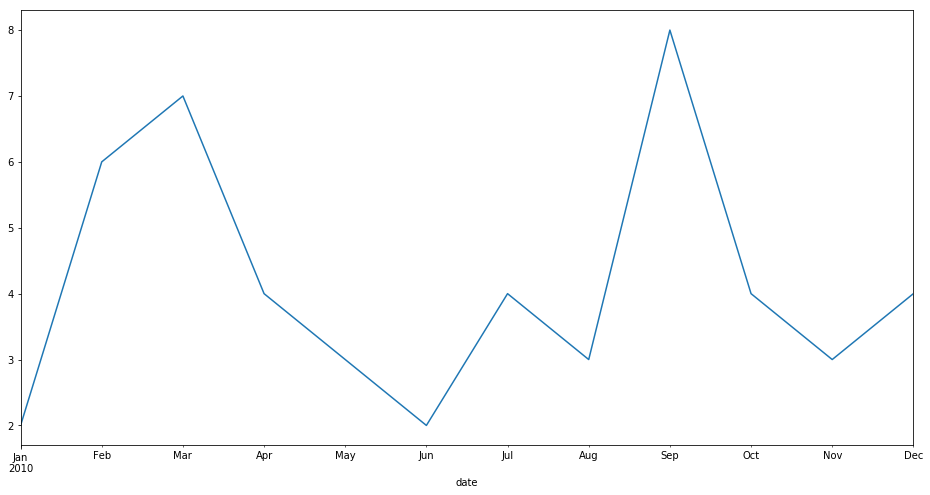

In [5]:
### Excerise consistency data check -do we have data elements for everything...any outliers
#print(dataM["2010":"2010"]["month_name"])
plt.figure(figsize=(16,8))
dataM["2010":"2010"]["Wet"].plot()

Text(0.5, 1.0, '2016 myPWS')

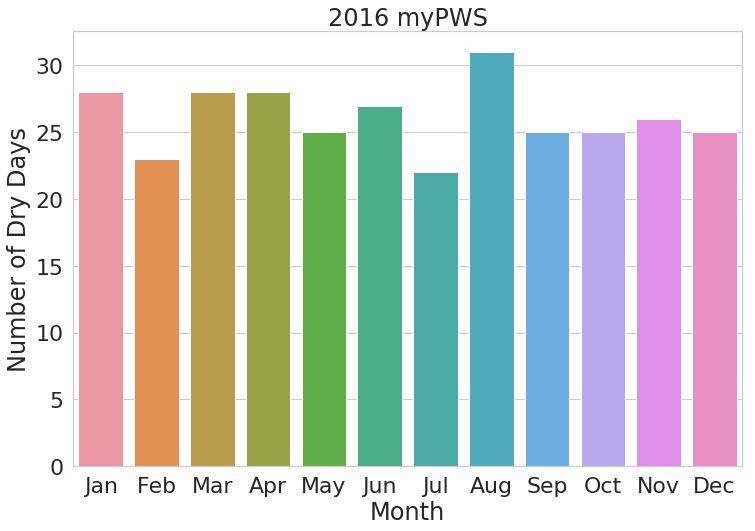

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Monthly plot of rainy days
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Dry",  data=dataM["2016-01":"2016-12"])

plt.xlabel("Month")
plt.ylabel("Number of Dry Days")
plt.title("2016 {}".format(station))


## Forecasting via SARIMAX
#### Quick look at trends

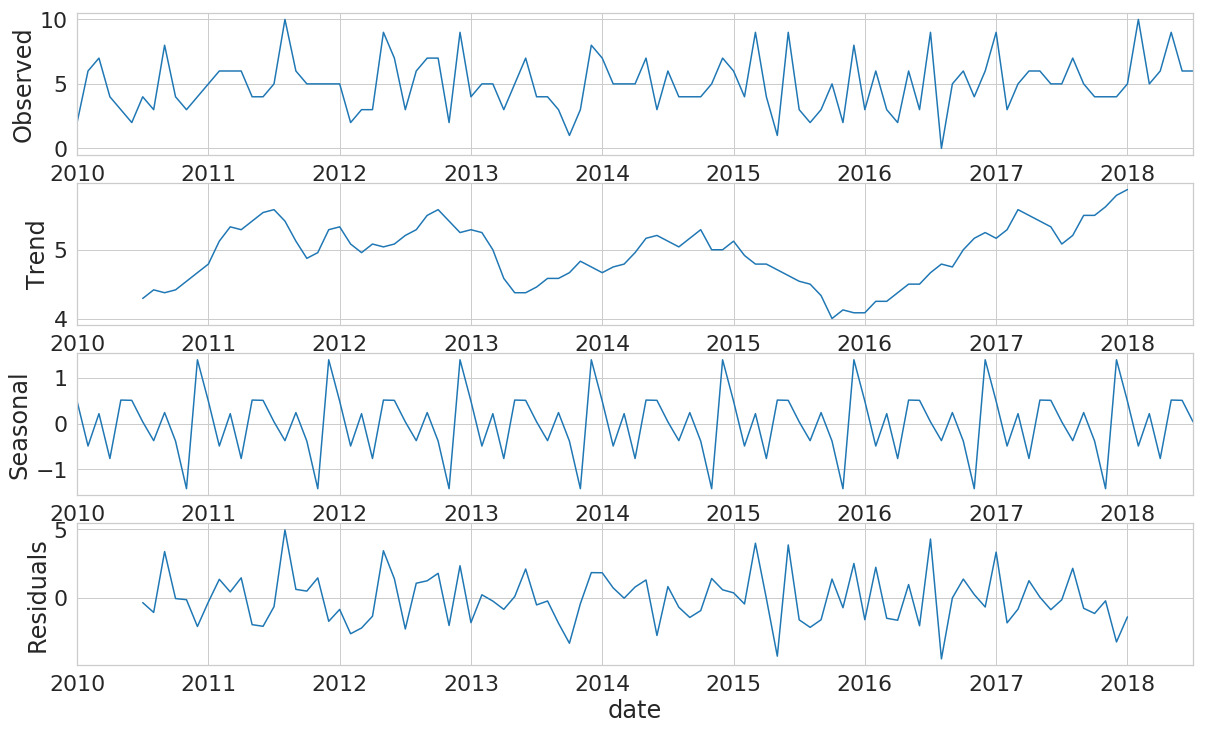

In [7]:
import statsmodels.api as sm
# Let's decompose the time series to visualize trend, season and noise separately 
def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(20,12))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition
#decomposeNplot(train['T (degC)'])
decomposeNplot(dataM['Wet'])
#decomposeNplot(dataWeekly['rainday'])

In [8]:
# Let's check for stationarity (Augmented Dickey Fuller test)
#“Stationary” usually refers to time series data. A timeseries is stationary if it has no drift/trend. 
#Equivalently, it's mean stays roughly constant. It's important because most statistical methods get weird 
#(and go wrong) when timeseries aren't stationary.
#https://stats.stackexchange.com/questions/55805/how-do-you-interpret-results-from-unit-root-tests
# P-value has to be smaller than 0.05 to be stationarity    
from statsmodels.tsa.stattools import adfuller
#results = adfuller(dataD)
#print(results)
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(dataM['Wet'])
#adf_test(dataWeekly['rainday'])

Results of Dickey-Fuller Test:
Test Statistic                -1.112305e+01
p-value                        3.427680e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


### Create SARIMAX Model

In [22]:
## Resampling the data to mothly and averaging out the temperature & we will predict the monthly average temperature
train = dataM[:'2016']
test =  dataM['2016':]
alldata=dataM[:'2018-03']['Dry']
#alldata=dataM[:'2017-07']['Dry']
ftraindata = train['2016']['Dry']
ftestdata = test['Dry']

#dataWeekly['rainday']
#train = dataWeekly['2015':'2016']
#test =  dataWeekly['2016':]
#alldata=dataM['dataWeekly']
#alldata=dataWeekly['2015':'2018-04']['rainday']
#ftraindata = train['rainday']
#ftestdata = test['rainday']

from statsmodels.tsa.statespace.sarimax import SARIMAX
#endog.index = endog.datetime
#
#endog = endog.drop(['T (degC)'])

#exog.index = exog.dates
#exog = exog.drop(['dates'], axis = 1)
#Weekly 
#model = SARIMAX(alldata,order=(2,0,2),seasonal_order=(1,1,0,52),trend='ct', freq='W')#,endog = dataW  ,exog=dataW,
#Monthly
model = SARIMAX(alldata,order=(1, 0, 2),seasonal_order=(1, 1, 0, 12),trend='n',  freq='M',enforce_stationarity=True)
#model = SARIMAX(dataM['Dry'],order=(2,0,2),trend='n',freq='M',enforce_stationarity=True)
#(2, 0, 2)xh(1, 1, 0, 52)
results = model.fit()

print(np.mean(np.abs(results.resid)))

results.summary()


5.0104082778671915


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                Dry   No. Observations:                   99
Model:             SARIMAX(1, 0, 2)x(1, 1, 0, 12)   Log Likelihood                -206.403
Date:                            Mon, 04 May 2020   AIC                            422.806
Time:                                    19:53:20   BIC                            435.136
Sample:                                01-31-2010   HQIC                           427.771
                                     - 03-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8945      0.140      6.376      0.000       0.620       1.169
ma.L1         -1.0224     12.888     -0.079      0.937     -26.282      24.237
ma.L2          0.0225      0.364      0.062      0.951      -0.692       0.737
ar.S.L12      -0.5531      0.126     -4.374      0.000      -0.801      -0.305
sigma2         6.2357     79.889      0.078      0.938    -150.344     162.815
===================================================================================
Ljung-Box (Q):                       29.49   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.89   Prob(JB):                         0.77
Heteroskedasticity (H):               1.13   Skew:                            -0.11
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
#STEPS = Month eg 2 years
forecast = results.get_forecast(steps=30)#len(ftestdata)) 
forecast.predicted_mean.head(10).round()
#results(1).plot_diagnostics(figsize=(10,10))
#results.summary()
#forecast.conf_int().round()
#forecast.conf_int().iloc[:,0].round()

2018-04-30    27.0
2018-05-31    26.0
2018-06-30    27.0
2018-07-31    24.0
2018-08-31    28.0
2018-09-30    25.0
2018-10-31    26.0
2018-11-30    26.0
2018-12-31    26.0
2019-01-31    24.0
Freq: M, dtype: float64

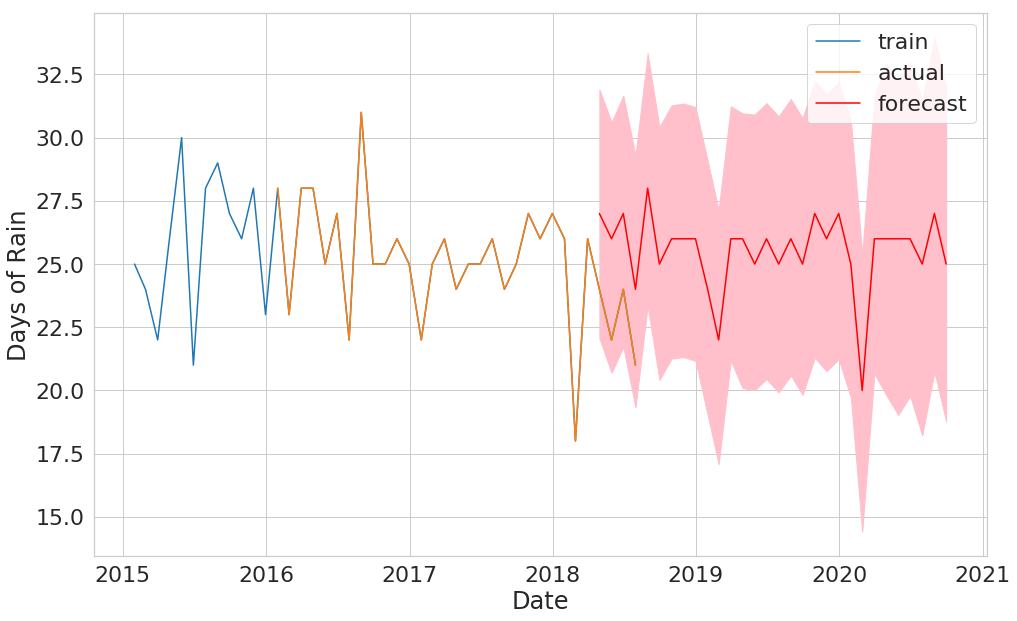

2018-04-30    27.0
2018-05-31    26.0
2018-06-30    27.0
2018-07-31    24.0
2018-08-31    28.0
Freq: M, dtype: float64

In [25]:
### Visualize our forecasted data
#
# Excerise try to use different data ranges 
#
train = dataM[:'2015']
test =  dataM['2015':'2016']
alldata=dataM['2016':]['Dry']
ftraindata = dataM['2015':]['Dry']
ftestdata = test['Dry']

#dataWeekly['rainday']
#train = dataWeekly['2016':'2016']
#test =  dataWeekly['2016':]
#alldata=dataWeekly['2016-07':].rainday
#alldata=dataWeekly[:'2017-07']['rainday']
#ftraindata = train['rainday']
#ftestdata = test['rainday']

bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]
plt.figure(figsize=(16,10))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(alldata.index,alldata,label='actual')

plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.round(), color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')

plt.xlabel('Date')
plt.ylabel('Days of Rain')
plt.legend()
plt.show()
#predictedmean.head().round()
forecast.predicted_mean.head().round()

### Merging forecast to our dataset

In [11]:
#
# Note: we will have 2 datasets ...DataM - history dataset
# ...DataF - Forecast dataset
#
#
dataF = pd.DataFrame(forecast.predicted_mean.round())
dataF.columns  = ['Dry']
dataF['Wet']   = dataF['Dry'] 
#dataF['Wet']  = dataF['days']-dataF['fDry'] 
dataF['date']  = dataF.index
dataF['date']  = pd.to_datetime(dataF['date'])#
dataF['year']  = pd.DatetimeIndex(dataF['date']).year
dataF['month'] = pd.DatetimeIndex(dataF['date']).month
dataF['days']  = pd.DatetimeIndex(dataF['date']).day
dataF['Wet']   = dataF['days']-dataF['Dry'] 
#dataF['Dry'] = dataF['fDry'] 

dataF["month_name"] = dataF.month.apply(lambda x: calendar.month_abbr[x])
#dataF.drop(colmun="Dry")
#Query Testing
yy="2020"
mm="Jun"
dry=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][0]
wet=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][1]
getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}  
print(getInfo)
print(dataF['2020':'2020'].loc[dataF['month_name']  == "Jun"].values[0][6])
#dataF['2020':'2020'].loc[dataF['month_name']  == "Jan"]
dataF['2020':]
#sel= dataF["2020-01":"2020-03"]
#sel.reset_index().to_json(orient='records')

{'Wet': 4.0, 'Dry': 26.0, 'Month': 'Jun', 'Year': '2020'}
Jun


,Dry,Wet,date,year,month,days,month_name
2020-01-31,25.0,6.0,2020-01-31,2020,1,31,Jan
2020-02-29,20.0,9.0,2020-02-29,2020,2,29,Feb
2020-03-31,26.0,5.0,2020-03-31,2020,3,31,Mar
2020-04-30,26.0,4.0,2020-04-30,2020,4,30,Apr
2020-05-31,26.0,5.0,2020-05-31,2020,5,31,May
2020-06-30,26.0,4.0,2020-06-30,2020,6,30,Jun
2020-07-31,25.0,6.0,2020-07-31,2020,7,31,Jul
2020-08-31,27.0,4.0,2020-08-31,2020,8,31,Aug
2020-09-30,25.0,5.0,2020-09-30,2020,9,30,Sep


### Query Playgroud

In [12]:
# GetInfo
dataY = dataF.resample('Y').mean(); # yearly averages
dataY.year.count()
getInfo = '{"cmd":"getInfo","tablesize":'+str(len(dataM))+',"years":'+str(dataY.year.count())+'}'; # yearly averages

print(getInfo)


{"cmd":"getInfo","tablesize":103,"years":3}


In [13]:
#getMay2020
datain = {'cmd' : 'getMay2020'}
dry=dataF["2020":].loc[dataF['month_name'] == 'Apr'].values[0][0] #fDry
wet=dataF["2020":].loc[dataF['month_name'] == 'Apr'].values[0][1]
yy= dataF["2020":].loc[dataF['month_name'] == 'Apr'].values[0][3]
mm= dataF["2020":].loc[dataF['month_name'] == 'Apr'].values[0][6]
#temp=dataF["2020":].loc[dataF['month_name'] == 'Apr'].values[0][4]
mvk = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
mvk["cmd"]=datain['cmd']
mvk

{'Wet': 4.0, 'Dry': 26.0, 'Month': 'Apr', 'Year': 2020, 'cmd': 'getMay2020'}

In [14]:
#getForecastMonth
yy='2020'
mm='Jun'
dry=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][0]
wet=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][1]
getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
    
print(getInfo)

{'Wet': 4.0, 'Dry': 26.0, 'Month': 'Jun', 'Year': '2020'}


In [15]:
#getForecastRange
datain={"cmd":"getForecastRange","start":"2019-01","end":"2019-03"}
startym=datain['start'] 
endym=datain['end'] 
sel= dataF[startym:endym]
mvk=sel.reset_index().to_json(orient='records')
getInfo={"cmd":"getForecastRange","info":[]}
info=json.loads(mvk)  
getInfo['info']=info
dataF[startym:endym]

,Dry,Wet,date,year,month,days,month_name
2019-01-31,24.0,7.0,2019-01-31,2019,1,31,Jan
2019-02-28,22.0,6.0,2019-02-28,2019,2,28,Feb
2019-03-31,26.0,5.0,2019-03-31,2019,3,31,Mar


In [16]:
#if (datain['cmd'] == 'getRange'):  
#
# You could add or remove data elements !!!! 
#
datain={"cmd":"getRange","start":"2017-01","end":"2017-04"}
startym=datain['start'] 
endym=datain['end'] 
sel= dataM[startym:endym]
mvk=sel.reset_index().to_json(orient='records')
getInfo={"cmd":"cmd","info":[]}
info=json.loads(mvk)  
#info

In [17]:
datain={"cmd":"getRange","start":"2020-01","end":"2020-04"}
dry=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][0]
wet=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][1]
getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
getInfo["cmd"]=datain['cmd']    
#getInfo

In [18]:
print("Hello")

Hello


## Connection to Node-RED <> python
### Make sure to adjust the url below with your Node-RED instance

In [ ]:
#Create commincaton with Node-RED instance 
#You need to instal the client 1st
!pip install websocket-client

import websocket
import _thread
import time
import json

def on_open(ws):
    print("on open")
    def run(*args):
        for i in range(10000):
            hbeat = '{"cmd":"Python NB HeartBeat"}'
            print("send cmd")
            ws.send(hbeat)
            time.sleep(1000)
            
    _thread.start_new_thread(run, ())

def on_error(ws, error):
    print(error)

def on_close(ws):
    print("closed")
#    start_websocket_listener()
#    ws.send("Watson Studio Listen End")

def on_message(ws, message):
    print(message)
    wet=-1
    kw=0
    dry=-1
    kd=0
    try:
        datain = json.loads(message)
        print(datain['cmd'])
        # do the required stuff
        # add more iformation maybe even the min/max temperature of the year
        if (datain['cmd'] == 'hello'): # Add  more infos like numer of year/month
            getInfo = '{"cmd":"hello","message":"hello to Node-RED."}'                     ### <<<<< Change the hello return message 
            print(getInfo)
            ws.send(getInfo)
            
        if (datain['cmd'] == 'getInfo'): # Add  more infos like numer of year/month
            getInfo = '{"cmd":"getInfo","tablesize":'+str(len(dataM))+'}'
            print(getInfo)
            ws.send(getInfo)
            
        if (datain['cmd'] == 'getJan2017'):          
            dry=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][0]
            wet=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][1]
            yy=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][2]
            mm=dataM["2017":"2017"].loc[dataM['month_name'] == 'Jan'].values[0][3]
            getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
        #Get Rain for a month Month  in coming {"cmd":"getRain","month":"Feb","year":"2018"}
        if (datain['cmd'] == 'getRain'):  
            yy=datain['year'] 
            mm=datain['month'] 
            dry=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][0]
            wet=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][1]
            getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
#  
# Carefull with the Ranges - new function
#
        if (datain['cmd'] == 'getForecastMonth'):  
            yy=datain['year'] 
            mm=datain['month'] 
            dry=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][0]
            wet=dataF[yy:yy].loc[dataF['month_name'] == mm].values[0][1]
            getInfo = {'Wet': wet,'Dry' : dry,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
            
        if (datain['cmd'] == 'getForecastRange'):  
            startym=datain['start'] 
            endym=datain['end'] 
            sel= dataF[startym:endym]
            mvk=sel.reset_index().to_json(orient='records')
            getInfo={"cmd":"getForecastRange","info":[]}
            info=json.loads(mvk)  
            getInfo['info']=info
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
            
            
        if (datain['cmd'] == 'getRange'):  
            startym=datain['start'] 
            endym=datain['end'] 
            sel= dataM[startym:endym]
            mvk=sel.reset_index().to_json(orient='records')
            getInfo={"cmd":"cmd","info":[]}
            info=json.loads(mvk)  
            getInfo['info']=info
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))
            
        if (datain['cmd'] == 'getTemp'):  
            yy=datain['year'] 
            mm=datain['month'] 
            temp=dataM[yy:yy].loc[dataM['month_name'] == mm].values[0][4]
            getInfo = {'Temp' :temp,"Month" : mm ,"Year":yy}
            getInfo["cmd"]=datain['cmd']    
            print(getInfo)
            ws.send(json.dumps(getInfo))            
        if (datain['cmd'] == 'getAll'): 
            mysdata.to_json()
       
            
    except Exception as e:
        print("Error -  no json  / no  valid command?")
        print(e)
####   ws://thinklab2020nr.mybluemix.net/ws/myweather/"
#### use your own isntance 
def start_websocket_listener():
    #websocket.enableTrace(True)
    ws = websocket.WebSocketApp(mynoderedinstance, #<<<<<<< ADJUST
                              on_message = on_message,
                              on_error = on_error,
                              on_close = on_close)
    print("connecting")
   # ws.send("Watson Studio Listen open")
    ws.on_open = on_open
    ws.run_forever()

start_websocket_listener() 

connecting
on open
send cmd
{"cmd":"hello"}
hello
{"cmd":"hello","message":"hello to Node-RED."}
{"cmd":"hello"}
hello
{"cmd":"hello","message":"hello to Node-RED."}
{"cmd":"hello"}
hello
{"cmd":"hello","message":"hello to Node-RED."}
{"cmd":"hello"}
hello
{"cmd":"hello","message":"hello to Node-RED."}


In [ ]:
print("Hello")

<a id="authors"></a> 
### Authors

In [ ]:
# Markus van Kempen - mvk@ca.ibm.com
# Version:20200501

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.